# Portfolio Optimization Project
Kripa Bansal\
Sophia Ford\
Natalia Ramirez

Constructing a portfolio with the best possible balance of risk (variance) and expected return (mean returns). 

## Data Cleaning

In [133]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [134]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [135]:
# Stocks we will use
tickers = ['KRE', 'DIS', 'GOOGL', 'NG=F']
#Final and start dates
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)
print(end_date)
print(start_date)

2024-05-15 15:03:08.666829
2014-05-18 15:03:08.666829


### Reading Data

In [136]:
# Initialize a list to hold the DataFrames
dataframes = []

for name in tickers:
    # Download stock data for given ticker between the start and end dates
    data = yf.download(name, start=start_date, end=end_date)
    
    # Add a new column for the ticker name
    data['Ticker'] = name
    
    # Append the DataFrame to the list
    dataframes.append(data)

stock_info = pd.concat(dataframes)

stock_info.reset_index(inplace=True)

print(stock_info)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

            Date       Open       High        Low      Close  Adj Close  \
0     2014-05-19  37.119999  37.910000  37.119999  37.900002  30.090866   
1     2014-05-20  37.830002  37.880001  37.240002  37.509998  29.781210   
2     2014-05-21  37.740002  38.060001  37.450001  37.770000  29.987642   
3     2014-05-22  37.730000  38.070000  37.689999  37.959999  30.138494   
4     2014-05-23  37.939999  38.290001  37.919998  38.139999  30.281399   
...          ...        ...        ...        ...        ...        ...   
10054 2024-05-08   2.219000   2.274000   2.167000   2.187000   2.187000   
10055 2024-05-09   2.186000   2.316000   2.153000   2.301000   2.301000   
10056 2024-05-10   2.307000   2.344000   2.242000   2.252000   2.252000   
10057 2024-05-13   2.250000   2.384000   2.214000   2.381000   2.381000   
10058 2024-05-14   2.362000   2.397000   2.306000   2.344000   2.344000   

        Volume Ticker  
0      2799000    KRE  
1      3538600    KRE  
2      2137300    KRE  
3  

In [137]:
print(stock_info['Date'])

0       2014-05-19
1       2014-05-20
2       2014-05-21
3       2014-05-22
4       2014-05-23
           ...    
10054   2024-05-08
10055   2024-05-09
10056   2024-05-10
10057   2024-05-13
10058   2024-05-14
Name: Date, Length: 10059, dtype: datetime64[ns]


## Plotting Adj. Close Price

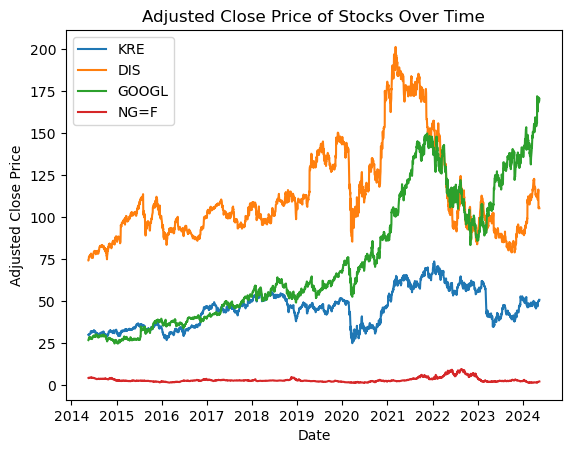

In [138]:
import matplotlib.pyplot as plt

# Create a plot to show closing price of each ticker
for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

# Show the plot
plt.show()

## Daily Simple Return

In [139]:
returns = pd.DataFrame()

for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    ticker_change = subset.set_index('Date')['Adj Close'].pct_change()  # Keep the date index

    returns[ticker] = ticker_change  # This ensures the Date remains as the index

returns.dropna(how='all', inplace=True)

# Check the resulting DataFrame
print(returns.head())

                 KRE       DIS     GOOGL      NG=F
Date                                              
2014-05-20 -0.010291  0.000494  0.002895  0.018345
2014-05-21  0.006932  0.013565  0.017228 -0.017355
2014-05-22  0.005030  0.001947  0.010460 -0.025486
2014-05-23  0.004742  0.011779  0.015033  0.010553
2014-05-27  0.012061  0.005041  0.019635  0.022701


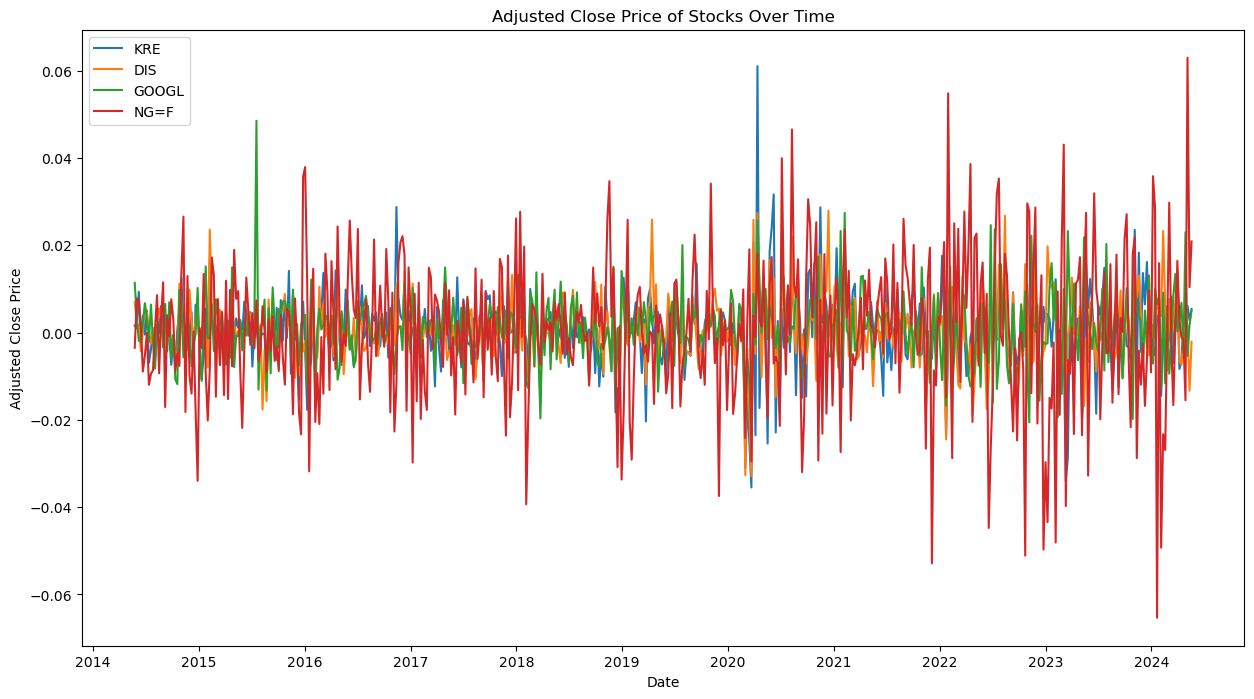

In [140]:
plt.figure(figsize=(15, 8))
weekly_returns = returns.resample('W').mean()
for ticker in returns.columns:
    plt.plot(weekly_returns.index, weekly_returns[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

plt.show()

## Creating Covariance Matrix

In [141]:
cov_matrix = returns.cov()
print(cov_matrix)

            KRE       DIS     GOOGL      NG=F
KRE    0.000378  0.000179  0.000129  0.000051
DIS    0.000179  0.000302  0.000133  0.000036
GOOGL  0.000129  0.000133  0.000314  0.000021
NG=F   0.000051  0.000036  0.000021  0.001470


### Mean Weights

In [142]:
mean_returns = returns.mean()
num_assets = len(returns.columns)

## Defining Metrics

Through mean, variance, and covariance we can formulate an optimization problem where you aim to minimize the portfolio's variance given expected returns or maximize the expected return for a given level of risk.\
**Formula:**
$\sigma^2_p = w^T \Sigma w$
### Efficient Frontier 
The set of optimal portfolios that offer the highest returns with a low level of risk or the lowest risk with the highest returns is known as the Efficient Frontier. 

In [143]:
 def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    # Weights must range from 0-1
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

Mean returns helps in estimating the expected return of each asset and thus the return of the whole portfolio

## Optimizing Weights

Identifying the portfolio with less mean variance 

In [144]:
from scipy.optimize import minimize
def portfolio_variance(weights):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def portfolio_sharpe(weights):
    return -((portfolio_performance(weights, mean_returns, cov_matrix)[1] - risk_free_rate) / portfolio_performance(weights, mean_returns, cov_matrix)[0])

In [145]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must be 1
bounds = tuple((0,1) for asset in range(num_assets)) 
risk_free_rate = 0.0001#We would like a risk of 1%

In [146]:
# All stocks have the same weights at the start
initial_weights = np.array(num_assets * [1. / num_assets])

In [147]:
# Minimum variance
optimal_var_min = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Maximize Sharpe Ratio
optimal_sharpe = minimize(portfolio_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

In [148]:
# Calculate unweighted returns using uniform weights
uniformly_weighted_returns = np.dot(returns, initial_weights.T)
unweighted_returns = returns.copy()
unweighted_returns['Unweighted_Returns'] = uniformly_weighted_returns
print(unweighted_returns.head())

                 KRE       DIS     GOOGL      NG=F  Unweighted_Returns
Date                                                                  
2014-05-20 -0.010291  0.000494  0.002895  0.018345            0.002861
2014-05-21  0.006932  0.013565  0.017228 -0.017355            0.005092
2014-05-22  0.005030  0.001947  0.010460 -0.025486           -0.002012
2014-05-23  0.004742  0.011779  0.015033  0.010553            0.010527
2014-05-27  0.012061  0.005041  0.019635  0.022701            0.014859


In [149]:
# Calculate optimized weighted returns
print('Optimal weights for minimum variance')
weights_min_var = optimal_var_min['x']
print(weights_min_var)
weighted_returns = np.dot(returns, weights_min_var.T)
returns['Weighted_Returns'] = weighted_returns 
returns.head()

Optimal weights for minimum variance
[0.20031396 0.32497251 0.36840394 0.10630959]


,KRE,DIS,GOOGL,NG=F,Weighted_Returns
Date,,,,,
2014-05-20,-0.010291,0.000494,0.002895,0.018345,0.001116
2014-05-21,0.006932,0.013565,0.017228,-0.017355,0.010299
2014-05-22,0.005030,0.001947,0.010460,-0.025486,0.002785
2014-05-23,0.004742,0.011779,0.015033,0.010553,0.011438
2014-05-27,0.012061,0.005041,0.019635,0.022701,0.013701


## Create features

Using rolling weighted returns, the standard deviation of the weighted returns, and the previous returns. Along with the rolling closing prices in a window of 10 and 50 days. 

### Weighted Returns

In [150]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-20,-0.010291,0.000494,0.002895,0.018345,0.001116,NaN,NaN,NaN
2014-05-21,0.006932,0.013565,0.017228,-0.017355,0.010299,NaN,NaN,0.001116
2014-05-22,0.005030,0.001947,0.010460,-0.025486,0.002785,NaN,NaN,0.010299
2014-05-23,0.004742,0.011779,0.015033,0.010553,0.011438,NaN,NaN,0.002785
2014-05-27,0.012061,0.005041,0.019635,0.022701,0.013701,NaN,NaN,0.011438


In [151]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
# Volatility
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns = returns.dropna(subset=['MA_10', 'STD_10'])
returns.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-06-03,0.003357,-0.004628,-0.017419,0.003686,-0.006857,0.003101,0.006574,0.000235
2014-06-04,0.002316,0.004292,-0.001353,0.002376,0.001613,0.003151,0.006559,-0.006857
2014-06-05,0.019255,0.006410,0.020171,0.013147,0.014769,0.003598,0.007219,0.001613
2014-06-06,0.010327,-0.002005,0.001947,0.001914,0.002338,0.003553,0.007226,0.014769
2014-06-09,0.015457,0.010283,0.008303,-0.013800,0.008030,0.003212,0.006885,0.002338


### Unweighted Returns

In [152]:
unweighted_returns['MA_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).mean()
unweighted_returns['STD_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).std()
unweighted_returns['Previous_Returns'] = unweighted_returns['Unweighted_Returns'].shift(1)
unweighted_returns.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-20,-0.010291,0.000494,0.002895,0.018345,0.002861,NaN,NaN,NaN
2014-05-21,0.006932,0.013565,0.017228,-0.017355,0.005092,NaN,NaN,0.002861
2014-05-22,0.005030,0.001947,0.010460,-0.025486,-0.002012,NaN,NaN,0.005092
2014-05-23,0.004742,0.011779,0.015033,0.010553,0.010527,NaN,NaN,-0.002012
2014-05-27,0.012061,0.005041,0.019635,0.022701,0.014859,NaN,NaN,0.010527


In [153]:
unweighted_returns['MA_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).mean()
unweighted_returns['STD_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).std()
unweighted_returns['Previous_Returns'] = unweighted_returns['Unweighted_Returns'].shift(1)
unweighted_returns = unweighted_returns.dropna(subset=['MA_10', 'STD_10'])
unweighted_returns.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-06-03,0.003357,-0.004628,-0.017419,0.003686,-0.003751,0.003143,0.005899,0.004303
2014-06-04,0.002316,0.004292,-0.001353,0.002376,0.001908,0.003047,0.005912,-0.003751
2014-06-05,0.019255,0.006410,0.020171,0.013147,0.014746,0.004013,0.006975,0.001908
2014-06-06,0.010327,-0.002005,0.001947,0.001914,0.003046,0.004519,0.006666,0.014746
2014-06-09,0.015457,0.010283,0.008303,-0.013800,0.005061,0.003972,0.006335,0.003046


### Original Stock DF Features

In [154]:
stock_info['Date'] = pd.to_datetime(stock_info['Date'])
# Set 'Date' as the index for both DataFrames.
stock_info.set_index('Date', inplace=True)
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2014-05-19,37.119999,37.910000,37.119999,37.900002,30.090866,2799000,KRE
2014-05-20,37.830002,37.880001,37.240002,37.509998,29.781210,3538600,KRE
2014-05-21,37.740002,38.060001,37.450001,37.770000,29.987642,2137300,KRE
2014-05-22,37.730000,38.070000,37.689999,37.959999,30.138494,1940800,KRE
2014-05-23,37.939999,38.290001,37.919998,38.139999,30.281399,1324900,KRE


In [155]:
stock_info['MA_10_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=10).mean())
stock_info['MA_50_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=50).mean())
stock_info = stock_info.dropna(subset=['MA_10_close', 'MA_50_close'])
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,MA_10_close,MA_50_close
Date,,,,,,,,,
2014-07-29,38.669998,38.990002,38.669998,38.709999,30.861568,1428900,KRE,30.987532,31.418584
2014-07-30,39.000000,39.330002,38.790001,39.070000,31.148571,3251800,KRE,30.953248,31.439738
2014-07-31,38.630001,39.040001,38.410000,38.430000,30.638338,3046700,KRE,30.941290,31.456881
2014-08-01,38.259998,38.480000,37.669998,37.860001,30.183905,2087600,KRE,30.854389,31.460806
2014-08-04,37.939999,38.119999,37.430000,37.790001,30.128101,3393200,KRE,30.774665,31.460598


In [156]:
unweighted_merged_df = unweighted_returns.merge(stock_info[['MA_10_close', 'MA_50_close']], left_index=True, right_index=True, how='left')
unweighted_merged_df.dropna(subset=['MA_10_close', 'MA_50_close'], inplace=True)
unweighted_merged_df.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns,MA_10_close,MA_50_close
Date,,,,,,,,,,
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.000642,-0.002571,0.010057,-0.001936,30.987532,31.418584
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.000642,-0.002571,0.010057,-0.001936,78.941454,77.704899
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.000642,-0.002571,0.010057,-0.001936,29.889050,28.808320
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.000642,-0.002571,0.010057,-0.001936,3.859000,4.357420
2014-07-30,0.009300,0.011717,0.002509,-0.005777,0.004437,-0.001540,0.010208,-0.000642,30.953248,31.439738


In [157]:
merged_df = returns.merge(stock_info[['MA_10_close', 'MA_50_close']], left_index=True, right_index=True, how='left')
merged_df.dropna(subset=['MA_10_close', 'MA_50_close'], inplace=True)
merged_df.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns,MA_10_close,MA_50_close
Date,,,,,,,,,,
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.004826,-0.001335,0.009905,0.000888,30.987532,31.418584
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.004826,-0.001335,0.009905,0.000888,78.941454,77.704899
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.004826,-0.001335,0.009905,0.000888,29.889050,28.808320
2014-07-29,0.000517,-0.010901,-0.008464,0.016280,-0.004826,-0.001335,0.009905,0.000888,3.859000,4.357420
2014-07-30,0.009300,0.011717,0.002509,-0.005777,0.005981,-0.000031,0.009926,-0.004826,30.953248,31.439738


## Splitting data

Past dates are used as the training set, while future dates (dates after training) are the test set.

### Weighted Returns

In [158]:
merged_df = merged_df.sort_index()
split_point = int(len(merged_df) * 0.7)

X_train = merged_df.iloc[:split_point].drop(['Weighted_Returns'], axis=1)
y_train = merged_df.iloc[:split_point]['Weighted_Returns']
X_test = merged_df.iloc[split_point:].drop(['Weighted_Returns'], axis=1)
y_test = merged_df.iloc[split_point:]['Weighted_Returns']
print(merged_df.iloc[split_point:])

                 KRE       DIS     GOOGL      NG=F  Weighted_Returns  \
Date                                                                   
2021-06-15  0.014093 -0.013020 -0.008379 -0.033413         -0.008047   
2021-06-15  0.014093 -0.013020 -0.008379 -0.033413         -0.008047   
2021-06-15  0.014093 -0.013020 -0.008379 -0.033413         -0.008047   
2021-06-15  0.014093 -0.013020 -0.008379 -0.033413         -0.008047   
2021-06-16  0.014775 -0.006824 -0.005329  0.003395         -0.000860   
...              ...       ...       ...       ...               ...   
2024-05-13 -0.000993  0.000378  0.002905  0.057282          0.007084   
2024-05-14  0.011730 -0.004536  0.007095 -0.015540          0.001837   
2024-05-14  0.011730 -0.004536  0.007095 -0.015540          0.001837   
2024-05-14  0.011730 -0.004536  0.007095 -0.015540          0.001837   
2024-05-14  0.011730 -0.004536  0.007095 -0.015540          0.001837   

               MA_10    STD_10  Previous_Returns  MA_10_close  

### Unweighted Returns

In [159]:
unweighted_merged_df = unweighted_merged_df.sort_index()
split_point = int(len(unweighted_merged_df) * 0.7)

X_train_uw = unweighted_merged_df.iloc[:split_point].drop(['Unweighted_Returns'], axis=1)
y_train_uw = unweighted_merged_df.iloc[:split_point]['Unweighted_Returns']
X_test_uw = unweighted_merged_df.iloc[split_point:].drop(['Unweighted_Returns'], axis=1)
y_test_uw = unweighted_merged_df.iloc[split_point:]['Unweighted_Returns']

In [160]:
print("Training data date range:")
print("Start date:", X_train.index.min())
print("End date:", X_train.index.max())

# Print the date range for the test data
print("Test data date range:")
print("Start date:", X_test.index.min())
print("End date:", X_test.index.max())

Training data date range:
Start date: 2014-07-29 00:00:00
End date: 2021-06-14 00:00:00
Test data date range:
Start date: 2021-06-15 00:00:00
End date: 2024-05-14 00:00:00


## Model Definition

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

param_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [10,15,20,30],
    'max_features': [3, 5, 7],
    'n_estimators': [100, 200]
}

In [162]:
model_rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train_uw, y_train_uw)
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

best_params, best_score

Fitting 5 folds for each of 48 candidates, totalling 240 fits


({'max_depth': 3,
  'max_features': 5,
  'min_samples_split': 15,
  'n_estimators': 100},
 -0.007924192247126077)

In [163]:
cross_val_rmse_tree = cross_val_score(grid_search_rf.best_estimator_, X_test_uw, y_test_uw, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

print(f'RMSE of the stacking regressor on the test set: {cross_val_rmse_tree.mean()}')

RMSE of the stacking regressor on the test set: 0.008782211724146342


In [164]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# Create the models for ensemble

model1_r = Pipeline([('model', SVR())])
model2_r = Pipeline([('model', DecisionTreeRegressor())])
model3_r = Pipeline([('model', KNeighborsRegressor())])

                 
## Create the ensemble
my_ensemble_r = VotingRegressor(estimators=[('svr', model1_r),('tree', model2_r),('knn', model3_r)])

params_r = {'svr__model__kernel': ['linear', 'rbf', 'poly'],
           'svr__model__C': [1, 10, 50, 100],
           'tree__model__max_depth': [2,3,4,5], 
           'knn__model__n_neighbors': [10,25,50,100]
           }

grid_r = GridSearchCV(my_ensemble_r, param_grid=params_r, cv=5, scoring = 'neg_root_mean_squared_error').fit(X_train_uw, y_train_uw)

cross_val_rmse = cross_val_score(grid_r.best_estimator_, X_train_uw, y_train_uw, cv=5, scoring=make_scorer(mean_squared_error, squared=False))


print(f'Best Ensemble: {cross_val_rmse.mean()}');

Best Ensemble: 0.01007995107905629


In [165]:
# Creating ensemble from the best Random Forest model
best_random_forest = grid_search_rf.best_estimator_

stacked_r = StackingRegressor(estimators=[('voting', grid_r.best_estimator_)], final_estimator=DecisionTreeRegressor(max_depth=3))
stacked_ensemble = stacked_r

ensemble_voting = VotingRegressor(estimators=[
    ('random_forest', best_random_forest),
    ('stacked', stacked_ensemble)
])
ensemble_voting.fit(X_train_uw, y_train_uw)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(max_depth=3, max_features=5,
                                                   min_samples_split=15,
                                                   random_state=42)),
                            ('stacked',
                             StackingRegressor(estimators=[('voting',
                                                            VotingRegressor(estimators=[('svr',
                                                                                         Pipeline(steps=[('model',
                                                                                                          SVR(C=100))])),
                                                                                        ('tree',
                                                                                         Pipeline(steps=[('model',
                                                                                                          DecisionTreeRegressor(max_depth=5))])),
                                                                                        ('knn',
                                                                                         Pipeline(steps=[('model',
                                                                                                          KNeighborsRegressor(n_neighbors=10))]))]))],
                                               final_estimator=DecisionTreeRegressor(max_depth=3)))])

### Weighted Predictions

In [166]:
ensemble_predictions = ensemble_voting.predict(X_test)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f'RMSE of the VotingRegressor ensemble on the test set: {ensemble_rmse}')

RMSE of the VotingRegressor ensemble on the test set: 0.010143998960689623


### Unweighted Predictions

In [167]:
ensemble_predictions_uw = ensemble_voting.predict(X_test_uw)
ensemble_rmse_uw = np.sqrt(mean_squared_error(y_test_uw, ensemble_predictions_uw))
print(f'RMSE of the VotingRegressor ensemble on the test set: {ensemble_rmse_uw}')

RMSE of the VotingRegressor ensemble on the test set: 0.010809736450706391


## Analyzing Predictions

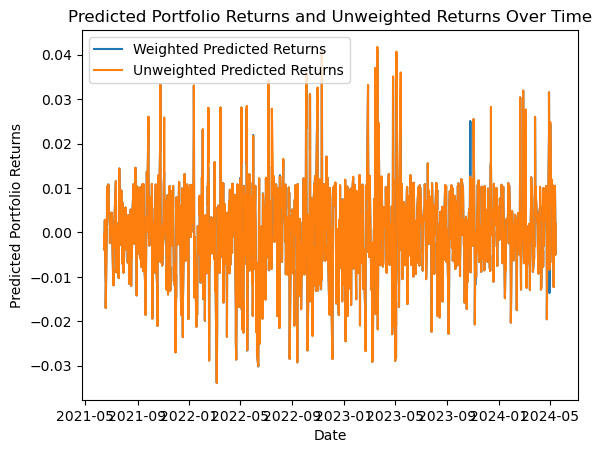

In [168]:
plt.plot(X_test.index, ensemble_predictions, label='Weighted Predicted Returns')
plt.plot(X_test_uw.index, ensemble_predictions_uw, label='Unweighted Predicted Returns')
# plt.plot(stock_returns.index, stock_returns['GOOGL'], label='Google Returns')
plt.xlabel('Date')
plt.ylabel('Predicted Portfolio Returns')
plt.title('Predicted Portfolio Returns and Unweighted Returns Over Time')
plt.legend()

plt.show()

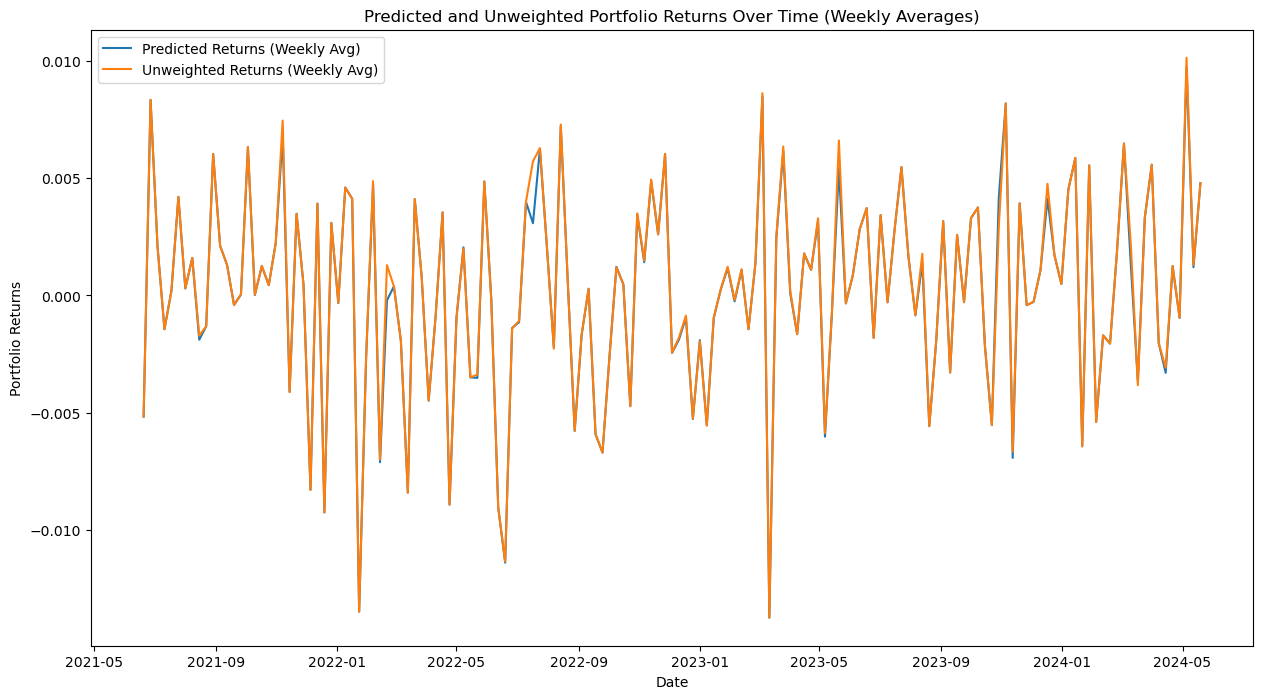

In [169]:
# Convert arrays to pandas Series (make sure `X_test.index` and `portfolio_df.index` are datetime indices)
predicted_returns_weighted = pd.Series(ensemble_predictions, index=X_test.index)
predicted_returns_unweighted = pd.Series(ensemble_predictions_uw, index=X_test_uw.index)

# Set the figure size
plt.figure(figsize=(15, 8))

# Resample the data to weekly averages
weekly_predicted_w = predicted_returns_weighted.resample('W').mean()
weekly_predicted_uw = predicted_returns_unweighted.resample('W').mean()

# Plot the resampled data
plt.plot(weekly_predicted_w.index, weekly_predicted_w, label='Predicted Returns (Weekly Avg)')
plt.plot(weekly_predicted_uw.index, weekly_predicted_uw, label='Unweighted Returns (Weekly Avg)')

# Labeling the axes and the plot
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Predicted and Unweighted Portfolio Returns Over Time (Weekly Averages)')
plt.legend()

# Show the plot
plt.show()

In [170]:
# Calculate the average predicted returns over the entire period
average_predicted_returns = weekly_predicted_w.std()

# Calculate the average unweighted returns over the entire period
average_unweighted_returns = weekly_predicted_uw.std()

print("Average Predicted Weighted Volatility over 3 years:", average_predicted_returns)
print("Average Predicted Unweighted Volatility over 3 years:", average_unweighted_returns)
print("Difference", average_unweighted_returns-average_predicted_returns)


Average Predicted Weighted Volatility over 3 years: 0.004315658361977362
Average Predicted Unweighted Volatility over 3 years: 0.004356018505008482
Difference 4.0360143031119636e-05


## Calculating Real Unweighted Returns

In [171]:
# Calculating Portfolio return before Optimizing
# Assign equal weights to each stock
weights = [1/4] * 4  # Four stocks, equal weight

stock_returns = merged_df[['KRE', 'DIS', 'GOOGL', 'NG=F']].iloc[split_point:]
portfolio_returns = stock_returns.dot(weights)
portfolio_df = pd.DataFrame({'Portfolio Returns': portfolio_returns})

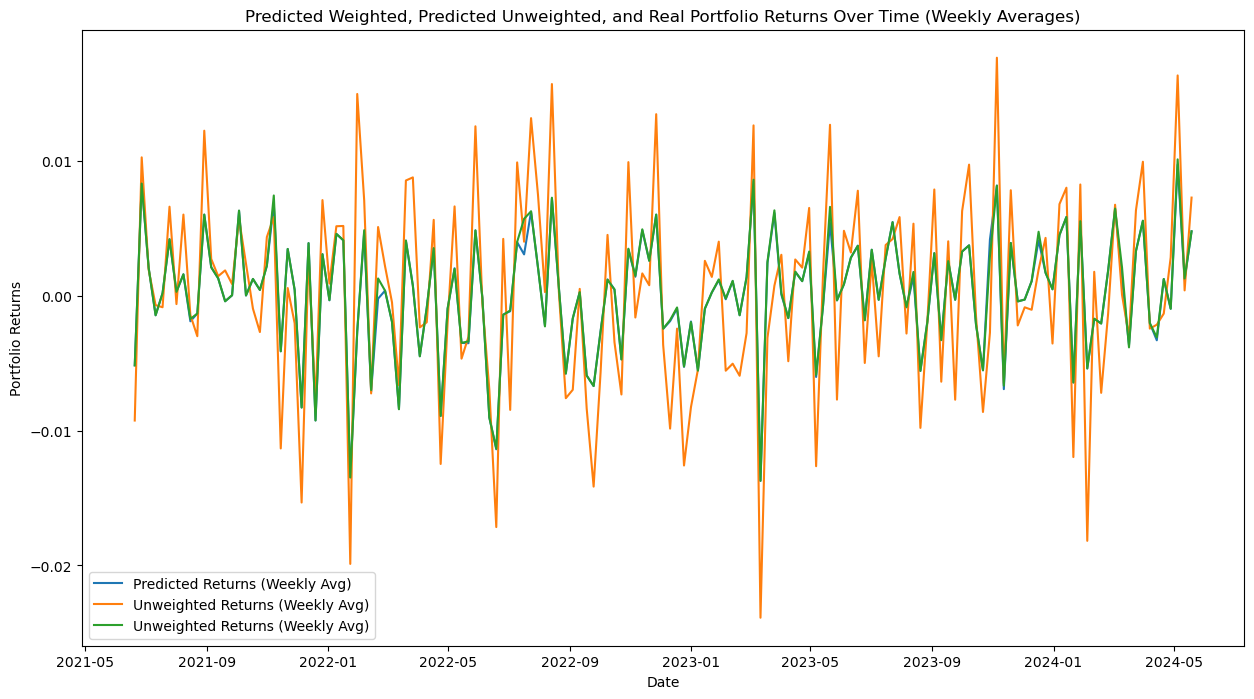

In [172]:
# Convert arrays to pandas Series (make sure `X_test.index` and `portfolio_df.index` are datetime indices)
predicted_returns_series = pd.Series(ensemble_predictions, index=X_test.index)
portfolio_returns_series = pd.Series(portfolio_df['Portfolio Returns'], index=portfolio_df.index)

# Set the figure size
plt.figure(figsize=(15, 8))

# Resample the data to weekly averages
weekly_predicted = predicted_returns_series.resample('W').mean()
weekly_unweighted = portfolio_returns_series.resample('W').mean()

# Plot the resampled data
plt.plot(weekly_predicted.index, weekly_predicted, label='Predicted Returns (Weekly Avg)')
plt.plot(weekly_unweighted.index, weekly_unweighted, label='Unweighted Returns (Weekly Avg)')
plt.plot(weekly_predicted_uw.index, weekly_predicted_uw, label='Unweighted Returns (Weekly Avg)')

# Labeling the axes and the plot
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Predicted Weighted, Predicted Unweighted, and Real Portfolio Returns Over Time (Weekly Averages)')
plt.legend()

# Show the plot
plt.show()

In [173]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale weighted and unweighted train and testing data
scaler = StandardScaler()
X_weighted_scaled = scaler.fit_transform(X_train)
X_unweighted_scaled = scaler.transform(X_train_uw)  
X_weighted_scaled_test = scaler.fit_transform(X_test)
X_unweighted_scaled_test = scaler.transform(X_test_uw)  

# Using LSTM model, create sequences first from the feature sets above
def create_sequences(X, y, n_steps=10):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i-n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Creating sequence for all train and test
n_steps = 10
X_weighted_seq, y_weighted_seq = create_sequences(X_weighted_scaled, y_train, n_steps)
X_unweighted_seq, y_unweighted_seq = create_sequences(X_unweighted_scaled, y_train_uw, n_steps)

X_weighted_seq_test, y_weighted_seq_test = create_sequences(X_weighted_scaled_test, y_test, n_steps)
X_unweighted_seq_test, y_unweighted_seq_test = create_sequences(X_unweighted_scaled_test, y_test_uw, n_steps)

# Define two LSTM models
def build_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Weighted Returns Model
model_weighted = build_model((n_steps, X_weighted_seq.shape[2]))
model_weighted.fit(X_weighted_seq, y_weighted_seq, epochs=10, validation_split=0.2)

# Unweighted Returns Model
model_unweighted = build_model((n_steps, X_unweighted_seq.shape[2]))
model_unweighted.fit(X_unweighted_seq, y_unweighted_seq, epochs=10, validation_split=0.2)

# seeing how it works
mse_weighted = model_weighted.evaluate(X_weighted_seq_test, y_weighted_seq_test)
mse_unweighted = model_unweighted.evaluate(X_unweighted_seq_test, y_unweighted_seq_test)

print(f'MSE for Weighted Returns Model: {mse_weighted:.4f}')
print(f'MSE for Unweighted Returns Model: {mse_unweighted:.4f}')


/var/folders/4d/502k74fx3h36x7jx51hngykw0000gn/T/ipykernel_2715/1293496391.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i])
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7345e-04 - val_loss: 0.0047
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6562e-04 - val_loss: 0.0035
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1662e-04 - val_loss: 0.0029
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8131e-05 - val_loss: 0.0025
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8690e-05 - val_loss: 0.0020
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1374e-05 - val_loss: 0.0020
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6231e-05 - val_loss: 0.0021
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0332e-05 - val_loss: 0.0017
Epoch 10/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5603e-05 - val_loss: 0.0015
Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - val_loss: 0.0186
Epoch 2/10
171/17

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


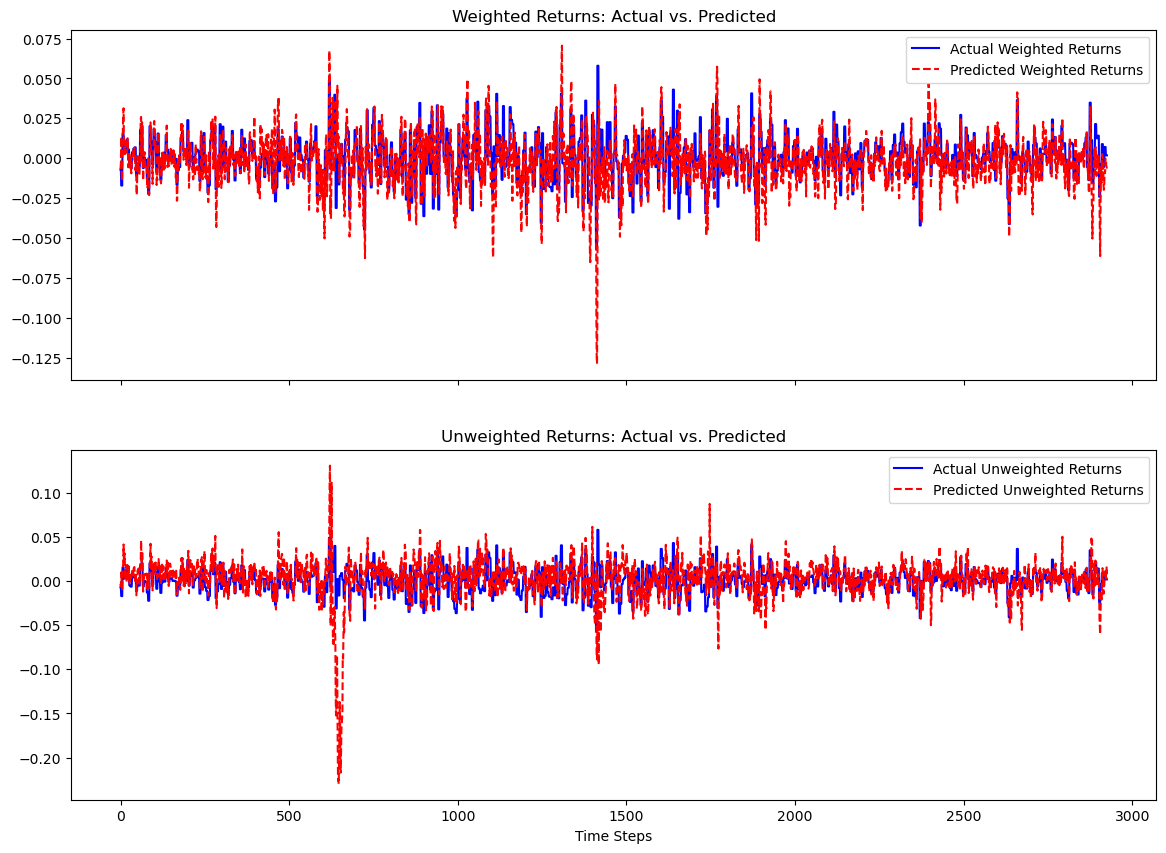

In [174]:
import matplotlib.pyplot as plt

# storing this stuff from above into a tidy dataframe type thing
predictions_weighted = model_weighted.predict(X_weighted_seq_test)
predictions_unweighted = model_unweighted.predict(X_unweighted_seq_test)

# the plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# weighted returns
axes[0].plot(y_weighted_seq_test, label='Actual Weighted Returns', color='blue')
axes[0].plot(predictions_weighted, label='Predicted Weighted Returns', color='red', linestyle='--')
axes[0].set_title('Weighted Returns: Actual vs. Predicted')
axes[0].legend()

# unweighted returns
axes[1].plot(y_weighted_seq_test, label='Actual Unweighted Returns', color='blue')
axes[1].plot(predictions_unweighted, label='Predicted Unweighted Returns', color='red', linestyle='--')
axes[1].set_title('Unweighted Returns: Actual vs. Predicted')
axes[1].legend()

plt.xlabel('Time Steps')
plt.show()


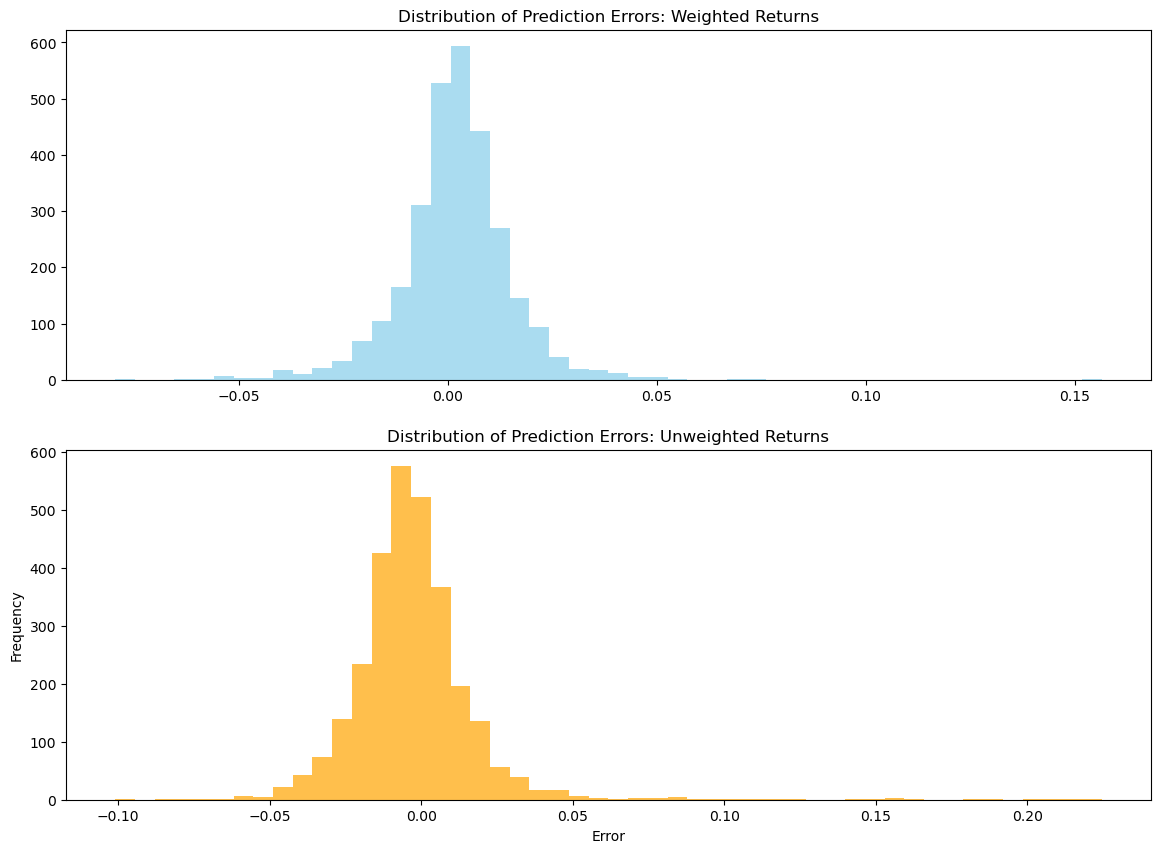

In [175]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# errors
errors_weighted = y_weighted_seq_test - predictions_weighted.flatten()
errors_unweighted = y_unweighted_seq_test - predictions_unweighted.flatten()

# plotting more errors
axes[0].hist(errors_weighted, bins=50, color='skyblue', alpha=0.7)
axes[0].set_title('Distribution of Prediction Errors: Weighted Returns')

# distribution
axes[1].hist(errors_unweighted, bins=50, color='orange', alpha=0.7)
axes[1].set_title('Distribution of Prediction Errors: Unweighted Returns')

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6489e-04 - val_loss: 0.0076
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1000e-04 - val_loss: 0.0048
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6390e-04 - val_loss: 0.0040
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2378e-04 - val_loss: 0.0031
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7475e-05 - val_loss: 0.0024
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0549e-05 - val_loss: 0.0022
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2955e-05 - val_loss: 0.0019
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4265e-05 - val_loss: 0.0018
Epoch 10/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1116e-05 - val_loss: 0.0019
Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 2/10
171/17

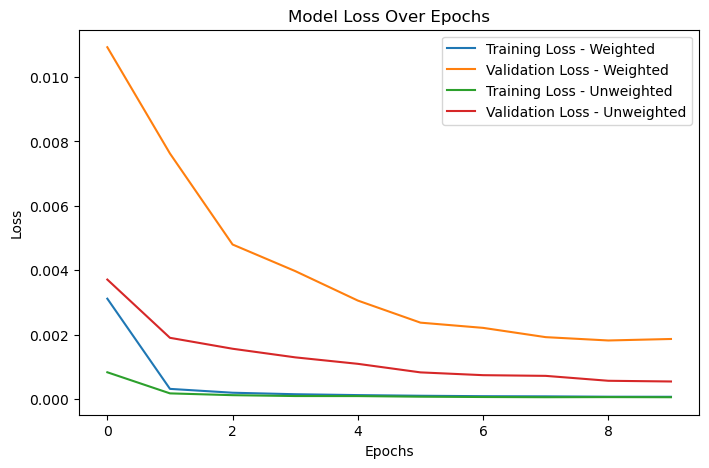

In [176]:
# The sequences help define the model so i could put it on a pretty graph, the shape (2) is standard because the data isn't that biased
model_weighted = build_model((n_steps, X_weighted_seq.shape[2]))
history_weighted = model_weighted.fit(X_weighted_seq, y_weighted_seq, epochs=10, validation_split=0.2)

# same for unweighted
model_unweighted = build_model((n_steps, X_unweighted_seq.shape[2]))
history_unweighted = model_unweighted.fit(X_unweighted_seq, y_unweighted_seq, epochs=10, validation_split=0.2)


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(history_weighted.history['loss'], label='Training Loss - Weighted')
ax.plot(history_weighted.history['val_loss'], label='Validation Loss - Weighted')
ax.plot(history_unweighted.history['loss'], label='Training Loss - Unweighted')
ax.plot(history_unweighted.history['val_loss'], label='Validation Loss - Unweighted')
ax.set_title('Model Loss Over Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


In [177]:
# Correct the index for predictions to match the y_test indices shifted by n_steps
predicted_weighted_series_nr = pd.Series(predictions_weighted.flatten(), index=X_test.index[n_steps:])
predicted_unweighted_series_nr = pd.Series(predictions_unweighted.flatten(), index=X_test.index[n_steps:])

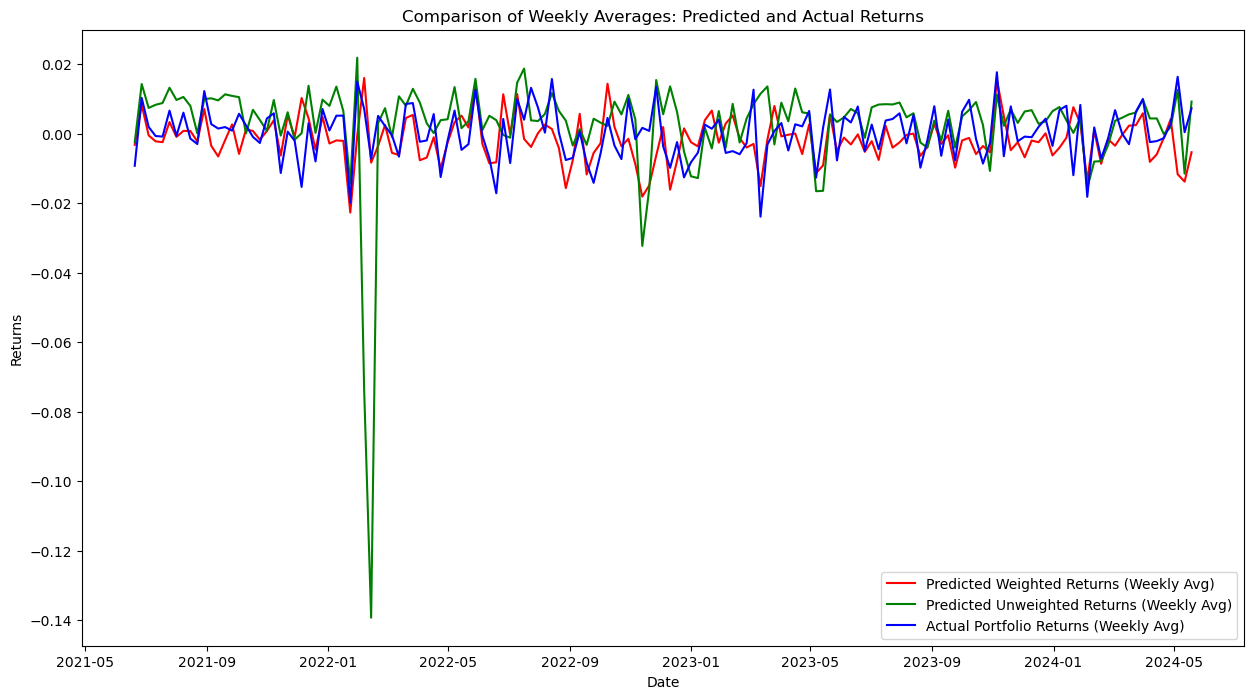

In [178]:
plt.figure(figsize=(15, 8))

weekly_predicted_w_nr = predicted_weighted_series_nr.resample('W').mean()
weekly_predicted_uw_nr = predicted_unweighted_series_nr.resample('W').mean()
weekly_portfolio_nr = portfolio_returns_series.resample('W').mean()  # Resample actual portfolio returns to weekly averages

plt.plot(weekly_predicted_w_nr.index, weekly_predicted_w_nr, label='Predicted Weighted Returns (Weekly Avg)', color='red')
plt.plot(weekly_predicted_uw_nr.index, weekly_predicted_uw_nr, label='Predicted Unweighted Returns (Weekly Avg)', color='green')
plt.plot(weekly_portfolio_nr.index, weekly_portfolio_nr, label='Actual Portfolio Returns (Weekly Avg)', color='blue')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Comparison of Weekly Averages: Predicted and Actual Returns')
plt.legend()

plt.show()

In [179]:
# Calculate the average predicted returns over the entire period
average_predicted_returns = weekly_predicted_w_nr.std()

# Calculate the average unweighted returns over the entire period
average_unweighted_returns = weekly_predicted_uw_nr.std()

print("Average Predicted Weighted Volatility over 3 years:", average_predicted_returns)
print("Average Predicted Unweighted Volatility over 3 years:", average_unweighted_returns)
print("Difference", average_unweighted_returns-average_predicted_returns)


Average Predicted Weighted Volatility over 3 years: 0.006328343413770199
Average Predicted Unweighted Volatility over 3 years: 0.015154681168496609
Difference 0.00882633775472641
